IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import string
import joblib as jb
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation,Input
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import plotly.express as px
import matplotlib.pyplot as plt
from keras.utils import plot_model

GETTING DATASET READY

In [2]:
#total features = 43
#41 main features
#last two are attack,level (severity of attack)

In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes'
                      ,'dst_bytes','land','wrong_fragment','urgent','hot'
                      ,'num_failed_logins','logged_in','num_compromised'
                      ,'root_shell','su_attempted','num_root'
                      ,'num_file_creations','num_shells','num_access_files'
                      ,'num_outbound_cmds','is_host_login','is_guest_login'
                      ,'count','srv_count','serror_rate'
                      ,'srv_serror_rate','rerror_rate','srv_rerror_rate'
                      ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate'
                      ,'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate'
                      ,'dst_host_diff_srv_rate','dst_host_same_src_port_rate'
                      ,'dst_host_srv_diff_host_rate','dst_host_serror_rate'
                      ,'dst_host_srv_serror_rate','dst_host_rerror_rate'
                      ,'dst_host_srv_rerror_rate','attack','level'])


In [4]:
train_data = pd.read_csv("/kaggle/input/nslkdd/KDDTrain+.txt",header=None,names=columns)
test_data = pd.read_csv("/kaggle/input/nslkdd/KDDTest+.txt",header=None,names=columns)

In [5]:
train_data.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15


In [6]:
test_data.shape

(22544, 43)

In [7]:
#DROP THE LAST COLUMN level as we don't need it from both train and test data
train_data.drop(columns=['level'],inplace=True)
test_data.drop(columns=['level'],inplace=True)

In [8]:
#CHECKING SHAPE OF TOTAL DATA
print("Train shape : ",train_data.shape,"Test shape : ",test_data.shape)

Train shape :  (125973, 42) Test shape :  (22544, 42)


In [9]:
#unique attacks
train_data.iloc[:,-1].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [10]:
#Some attack are of one type, we can group them together
#dos - flooding network with large traffic so that network has to be shutdown and unable to access by others
#probe - steal info from network
#u2r - start from normal user and tried to get access of root user
#r2l - trie to get local access to remote machine

dos = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe = ['ipsweep','mscan','nmap','portsweep','saint','satan']
u2r = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
r2l = ['ftp_write','guess_passwd','http_tunnel','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop']

#Use this attack labels
attacks = ['normal','dos','probe','u2r','r2l']

In [11]:
#creating map func
def m_a_p(x) :
    if(x in dos) : return "dos"
    elif(x in probe) : return "probe"
    elif(x in u2r) : return "u2r"
    elif(x in r2l) : return "r2l"
    else : return x

train_data["attack"] = train_data["attack"].map(m_a_p)
test_data["attack"] = test_data["attack"].map(m_a_p)

In [12]:
train_data["attack"].unique()

array(['normal', 'dos', 'r2l', 'probe', 'u2r'], dtype=object)

In [13]:
test_data["attack"].unique()

array(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype=object)

In [14]:
train_data.shape

(125973, 42)

In [15]:
#Train
#donut chart showing how many observations are given for each label in complete dataset
#hover over it to see actual value
fig = px.pie(values=train_data.iloc[:,41].groupby(train_data.iloc[:,41]).count()
             , names=train_data.iloc[:,41].groupby(train_data.iloc[:,41]).count().index
             , title="Complete Set", hole=0.5)
fig.update_layout(font=dict(color="white"),plot_bgcolor='rgb(0,0,0)'
                  ,paper_bgcolor='rgb(0,0,0)')  

In [16]:
#TEST
#donut chart showing how many observations are given for each label in complete dataset
#hover over it to see actual value
fig = px.pie(values=test_data.iloc[:,41].groupby(test_data.iloc[:,41]).count(),
             names=test_data.iloc[:,41].groupby(test_data.iloc[:,41]).count().index,
             title="Complete Set", hole=0.5)
fig.update_layout(font=dict(color="white"),plot_bgcolor='rgb(0,0,0)',
                  paper_bgcolor='rgb(0,0,0)')  

In [17]:
train_data.iloc[:,41].groupby(train_data.iloc[:,41]).count()

attack
dos       45927
normal    67343
probe     11656
r2l         995
u2r          52
Name: attack, dtype: int64

In [18]:
test_data.iloc[:,41].groupby(test_data.iloc[:,41]).count()

attack
dos       7460
normal    9711
probe     2421
r2l       2885
u2r         67
Name: attack, dtype: int64

In [19]:
#As you can see training set is unbalanced u2r,r2l,are very less as compared to other
#to make it balanced we can replicate data belongs to u2r , r2l multiple times

In [20]:
#r2l replicate it 11 times
t = train_data
for x in range(11) : 
    t = pd.concat([t,train_data[train_data["attack"] == "r2l"]],
                  axis='index')
new_train_data = t
new_train_data.iloc[:,41].groupby(new_train_data.iloc[:,41]).count()

attack
dos       45927
normal    67343
probe     11656
r2l       11940
u2r          52
Name: attack, dtype: int64

In [21]:
#u2r replicate it 220 times
t = new_train_data
for x in range(220) : 
    t = pd.concat([t,train_data[train_data["attack"] == "u2r"]],
                  axis='index')
new_train_data = t
new_train_data.iloc[:,41].groupby(new_train_data.iloc[:,41]).count()

attack
dos       45927
normal    67343
probe     11656
r2l       11940
u2r       11492
Name: attack, dtype: int64

In [22]:
#replicate probe,r2l,u2r once more
for i in range(2) :
    new_train_data = pd.concat([new_train_data,
                                new_train_data[new_train_data["attack"] == "probe"]],
                              axis = 'index')
    new_train_data = pd.concat([new_train_data,
                                new_train_data[new_train_data["attack"] == "u2r"]],
                              axis = 'index')
    new_train_data = pd.concat([new_train_data,
                                new_train_data[new_train_data["attack"] == "r2l"]],
                              axis = 'index')
new_train_data.iloc[:,41].groupby(new_train_data.iloc[:,41]).count()

attack
dos       45927
normal    67343
probe     46624
r2l       47760
u2r       45968
Name: attack, dtype: int64

In [23]:
#Train
#donut chart showing how many observations are given for each label in complete dataset
#hover over it to see actual value
fig = px.pie(values=new_train_data.iloc[:,41].groupby(new_train_data.iloc[:,41]).count()
             , names=new_train_data.iloc[:,41].groupby(new_train_data.iloc[:,41]).count().index
             , title="Complete Set", hole=0.5)
fig.update_layout(font=dict(color="white"),plot_bgcolor='rgb(0,0,0)'
                  ,paper_bgcolor='rgb(0,0,0)')  

In [24]:
#CONVERT CATEGORICAL VARIABLE TO NUMERICAL VALUES
#['normal','dos','probe','u2r','r2l'] -> [0,1,2,3,4]
new_train_data["attack"] = new_train_data["attack"].replace(attacks,range(len(attacks)))
test_data["attack"] = test_data["attack"].replace(attacks,range(len(attacks)))

/tmp/ipykernel_30/815788163.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_30/815788163.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [25]:
new_train_data["attack"].groupby(new_train_data["attack"]).count()

attack
0    67343
1    45927
2    46624
3    45968
4    47760
Name: attack, dtype: int64

In [26]:
#WE WILL CONSIDER FEATURE WITH LESS THAN 1000 UNIQUE VALUES 
#AS CATEGORICAL FEATURE
#SUM OF NUMBER OF UNIQUE VALUES OF EACH FEATURE WILL GIVE US
#TOTAL NUMBER OF FEATURES IN RESULTANT DATASET
#Not including attack

sm = 0
for col in new_train_data.iloc[:,:-1].columns : 
    
    tmp = len(pd.unique(new_train_data[col]))
    print(col,"    Number of Unique values : ",tmp)
    
    if(tmp < 1000) : 
        if(tmp == 2) : sm += (tmp - 1)
        else : sm += tmp
    else : sm += 1

print("Total number of columns in new dataset (not including label) : ",sm)

duration     Number of Unique values :  2981
protocol_type     Number of Unique values :  3
service     Number of Unique values :  70
flag     Number of Unique values :  11
src_bytes     Number of Unique values :  3341
dst_bytes     Number of Unique values :  9326
land     Number of Unique values :  2
wrong_fragment     Number of Unique values :  3
urgent     Number of Unique values :  4
hot     Number of Unique values :  28
num_failed_logins     Number of Unique values :  6
logged_in     Number of Unique values :  2
num_compromised     Number of Unique values :  88
root_shell     Number of Unique values :  2
su_attempted     Number of Unique values :  3
num_root     Number of Unique values :  82
num_file_creations     Number of Unique values :  35
num_shells     Number of Unique values :  3
num_access_files     Number of Unique values :  10
num_outbound_cmds     Number of Unique values :  1
is_host_login     Number of Unique values :  2
is_guest_login     Number of Unique values :  2


In [27]:
#function will drop categorical feature and create separate feature for each unique value of feature
#and there are 3 feature with more than 1000 number of unique values
def preprocess_cat_fea(df_train,df_test):
    df_new_train = pd.DataFrame()
    df_new_test = pd.DataFrame()
    continous_col = ['duration','src_bytes','dst_bytes',
                   'hot','num_failed_logins','num_compromised','num_root',
                   'num_file_creations','num_shells','num_access_files']
    for c in continous_col : 
        df_new_train[c] = df_train[c]
        df_new_test[c] = df_test[c]
    
    for col in df_train.iloc[:,:-1].columns : 
        if(col in continous_col) : continue
        lb = LabelBinarizer()
        lb.fit(df_train[col].astype('str'))
        lb.fit(df_test[col].astype('str'))
        trans_ = lb.transform(pd.concat([df_train[col],df_test[col]]).astype('str'))
        
        trans_train = pd.DataFrame(trans_[:df_train.shape[0],:],
                                   index=df_train.index)
        df_new_train = pd.concat([df_new_train,trans_train],axis=1)
        
        trans_test = pd.DataFrame(trans_[df_train.shape[0]:,:],
                                  index=df_test.index)
        df_new_test = pd.concat([df_new_test,trans_test],axis=1)
    return df_new_train,df_new_test

In [28]:
new_train_data.shape[0]

253622

In [29]:
new_train_data.isnull().any()

duration                       False
protocol_type                  False
service                        False
flag                           False
src_bytes                      False
dst_bytes                      False
land                           False
wrong_fragment                 False
urgent                         False
hot                            False
num_failed_logins              False
logged_in                      False
num_compromised                False
root_shell                     False
su_attempted                   False
num_root                       False
num_file_creations             False
num_shells                     False
num_access_files               False
num_outbound_cmds              False
is_host_login                  False
is_guest_login                 False
count                          False
srv_count                      False
serror_rate                    False
srv_serror_rate                False
rerror_rate                    False
s

In [30]:
new_train_data["serror_rate"].astype('str')

0         0.0
1         0.0
2         1.0
3         0.2
4         0.0
         ... 
125065    0.0
125118    0.0
125168    0.0
125169    0.0
125332    0.0
Name: serror_rate, Length: 253622, dtype: object

In [32]:
#dff - preprocessed dataset without label
X_train, X_test = preprocess_cat_fea(new_train_data,test_data)
Y_train = new_train_data["attack"]
Y_test = test_data["attack"]
X_train.head(2)

,duration,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,...,90,91,92,93,94,95,96,97,98,99
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_train.shape

(253622, 2941)

In [34]:
Y_train.shape

(253622,)

In [35]:
l = LabelBinarizer().fit([1,2,3,4])
print(l.classes_)
l.transform([8,8,1,1])

[1 2 3 4]


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [36]:
X_test.shape

(22544, 2941)

In [37]:
Y_test.shape

(22544,)

In [38]:
#split the dataset into training and testing set
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(dff, df[41], test_size=0.3, random_state=42, shuffle=True)

In [39]:
#EXCEPT 3 FEATURES REST ALL OF THE FEATURES ARE CATEOGORICAL FEATURES
#SO DOING MIN-MAX SCALER ON THOSE 3 FEATURES

continous_col = ['duration','src_bytes','dst_bytes',
                   'hot','num_failed_logins','num_compromised','num_root',
                   'num_file_creations','num_shells','num_access_files']
    
for c in continous_col : 
    mms = MinMaxScaler()
    X_train[c] = mms.fit_transform(np.reshape(np.array(X_train[c]),(-1,1)))
    X_test[c] = mms.transform(np.reshape(np.array(X_test[c]),(-1,1)))


In [40]:
X_train.columns = range(len(X_train.columns))
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_test.columns = range(len(X_test.columns))
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#Removing features with 0 variance or same values
vt = VarianceThreshold()
X_train = pd.DataFrame(vt.fit_transform(X_train),index=X_train.index)
X_train.shape

(253622, 2836)

In [43]:
X_test = pd.DataFrame(vt.transform(X_test),index=X_test.index)
X_test

,0,1,2,3,4,5,6,7,8,9,...,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835
0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000047,9.408217e-06,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,1.449313e-08,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000023,0.000000e+00,1.145093e-08,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.000000,5.753774e-07,2.542106e-07,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22540,0.000000,2.297162e-07,7.160648e-07,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22541,0.000000,3.952277e-05,6.346868e-06,0.025974,0.0,0.000134,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22542,0.000000,3.043558e-08,3.206260e-08,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


FEATURE SELECTION

In [44]:
#selecting 200 best feature after doing chi-squared on it
ishape = 200
skb = SelectKBest(chi2, k=ishape)
X_train = pd.DataFrame(skb.fit_transform(X_train, Y_train),index=X_train.index)
X_train

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125065,0.000000,0.012987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125118,0.000000,0.012987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125168,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
125169,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#selecting 200 best feature after doing chi-squared on it
X_test = pd.DataFrame(skb.transform(X_test),index=X_test.index)
X_test

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000047,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000023,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22540,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22541,0.000000,0.025974,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22542,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# #saving train and test set
# X_train.to_csv("/kaggle/input/nsl-kdd-data/X_train.csv",index=False)
# X_test.to_csv("/kaggle/input/nsl-kdd-data/X_test.csv",index=False)
# Y_train.to_csv("/kaggle/input/nsl-kdd-data/Y_train.csv",index=False)
# Y_test.to_csv("/kaggle/input/nsl-kdd-data/Y_test.csv",index=False)

In [47]:
# #load train and test set
# Xtrain = pd.read_csv("/content/drive/MyDrive/ai_sec_final/Xtrain.csv")
# Xtest = pd.read_csv("/content/drive/MyDrive/ai_sec_final/Xtest.csv")
# Ytrain = pd.read_csv("/content/drive/MyDrive/ai_sec_final/Ytrain.csv")
# Ytest = pd.read_csv("/content/drive/MyDrive/ai_sec_final/Ytest.csv")

TRAINING DIFFERENT MODELS

In [48]:
#function for geting accuracy
def get_acc(test,pred): return accuracy_score(test, pred)

In [49]:
#function for displaying accuracy,f1-score,confusion matrix,recall,precision
def show_report(test,pred,typ):
    print(typ+"============>>>")
    print("\nAccuracy : {:.4f}\n".format(accuracy_score(test, pred)))
    print("\nClassification report : \n", classification_report(test, pred))
    print("\nConfusion Matrix : \n", confusion_matrix(test, pred))

In [50]:
# accuracy vs epoch 
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
# loss vs epoch
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [51]:
#NEURAL NETWORK MODEL
def define_model(ishape):
    input1 = Input(shape=(ishape,))
    l1 = Dense(200)(input1)
    l2 = BatchNormalization()(l1)
    l3 = Activation('relu')(l2)
    l4 = Dropout(0.6)(l3)
    l5 = Dense(100)(l4)
    l6 = BatchNormalization()(l5)
    l7 = Activation('relu')(l6)
    l8 = Dropout(0.4)(l7)
    outputs = Dense(5, activation='softmax')(l8)
    
    model = Model(inputs=input1, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model

In [53]:
#RUNNING 5-FOLD CROSS VALIDATION ON DIFFERENT MODELS

results = {"mnb":[],"bnb":[],"lr":[],"rf":[],"svm":[]}

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(max_iter=1000,n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=25)
svc = svm.SVC(C=5)

kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_ix,test_ix in kFold.split(X_train,Y_train) : 
    
    train_X, test_X = X_train.iloc[train_ix,:], X_train.iloc[test_ix,:]
    train_y, test_y = Y_train.iloc[train_ix], Y_train.iloc[test_ix]
    
    mnb.fit(train_X,train_y)
    pred_test = mnb.predict(test_X)
    results["mnb"].append(get_acc(test_y,pred_test))
    
    bnb.fit(train_X,train_y)
    pred_test = bnb.predict(test_X)
    results["bnb"].append(get_acc(test_y,pred_test))
    
    lr.fit(train_X,train_y)
    pred_test = lr.predict(test_X)
    results["lr"].append(get_acc(test_y,pred_test))
    
    rf.fit(train_X,train_y)
    pred_test = rf.predict(test_X)
    results["rf"].append(get_acc(test_y,pred_test))
    
    svc.fit(train_X,train_y)
    pred_test = svc.predict(test_X)
    results["svm"].append(get_acc(test_y,pred_test))
    

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/

In [54]:
#running the neural network
nn = define_model(ishape)
history = nn.fit(X_train,Y_train,batch_size=100,epochs=100,validation_split=0.2,verbose=1)

Epoch 1/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9058 - loss: 0.2722 - val_accuracy: 0.9865 - val_loss: 0.0386
Epoch 2/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9811 - loss: 0.0578 - val_accuracy: 0.9855 - val_loss: 0.0376
Epoch 3/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9855 - loss: 0.0449 - val_accuracy: 0.9886 - val_loss: 0.0287
Epoch 4/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9872 - loss: 0.0391 - val_accuracy: 0.9878 - val_loss: 0.0292
Epoch 5/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9876 - loss: 0.0356 - val_accuracy: 0.9888 - val_loss: 0.0257
Epoch 6/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9888 - loss: 0.0325 - val_accuracy: 0.9884 - val_loss: 0.0263
Epoch 7/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9892 - loss: 0.0324 - val_accuracy: 0.9888 - val_loss: 0.0253
Epoch 8/100
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9898 - loss: 

In [55]:
# #dumping the models and kfold results
# jb.dump(mnb,"/content/drive/MyDrive/ai_sec_final/multinomialNB")
# jb.dump(bnb,"/content/drive/MyDrive/ai_sec_final/bernoulliNB")
# jb.dump(lr,"/content/drive/MyDrive/ai_sec_final/logisticRegression")
# jb.dump(rf,"/content/drive/MyDrive/ai_sec_final/randomForest")
# jb.dump(svc,"/content/drive/MyDrive/ai_sec_final/svm")
# jb.dump(results,"/content/drive/MyDrive/ai_sec_final/KFold_result")
# jb.dump(history,"/content/drive/MyDrive/ai_sec_final/neuralNetwork_history")
# nn.save("/content/drive/MyDrive/ai_sec_final/Neural_Network.h5")

TESTING DIFFERENT MODELS & OTHER INFORMATION ABOUT PREVIOUS RESULTS AND MODELS

In [56]:
# #loading the models
# mnb = jb.load("/content/drive/MyDrive/ai_sec_final/multinomialNB")
# bnb = jb.load("/content/drive/MyDrive/ai_sec_final/bernoulliNB")
# lr = jb.load("/content/drive/MyDrive/ai_sec_final/logisticRegression")
# rf = jb.load("/content/drive/MyDrive/ai_sec_final/randomForest")
# svc = jb.load("/content/drive/MyDrive/ai_sec_final/svm")
# nn = load_model("/content/drive/MyDrive/ai_sec_final/Neural_Network.h5")

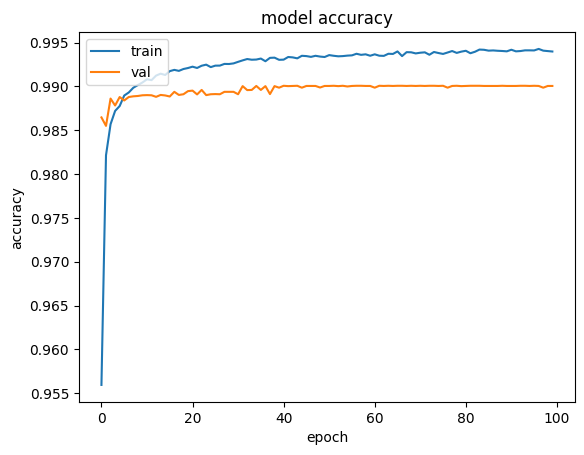

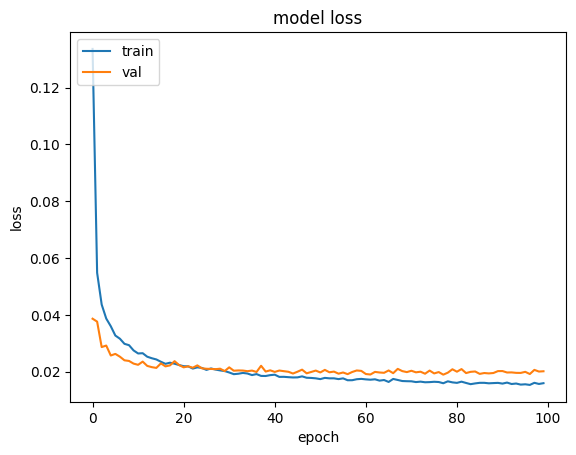

In [57]:
#ploting the graphs for later 100 epochs training and validation
#history = jb.load("/content/drive/MyDrive/ai_sec_final/neuralNetwork_history")
plot_acc(history)
print("\n")
plot_loss(history)

In [58]:
#results got from 5-Fold CROSS VALIDATION column = result per model
#results = jb.load("/content/drive/MyDrive/ai_sec_final/KFold_result")
pd.DataFrame(results)

,mnb,bnb,lr,rf,svm
0,0.915761,0.905786,0.981922,0.994539,0.991858
1,0.916136,0.905924,0.983066,0.995111,0.992331
2,0.918579,0.905765,0.982631,0.994184,0.991464
3,0.915543,0.905272,0.982493,0.995229,0.991996
4,0.915228,0.904601,0.982691,0.994933,0.992114


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,817 (721.95 KB)

 Trainable params: 61,405 (239.86 KB)

 Non-trainable params: 600 (2.34 KB)

 Optimizer params: 122,812 (479.74 KB)

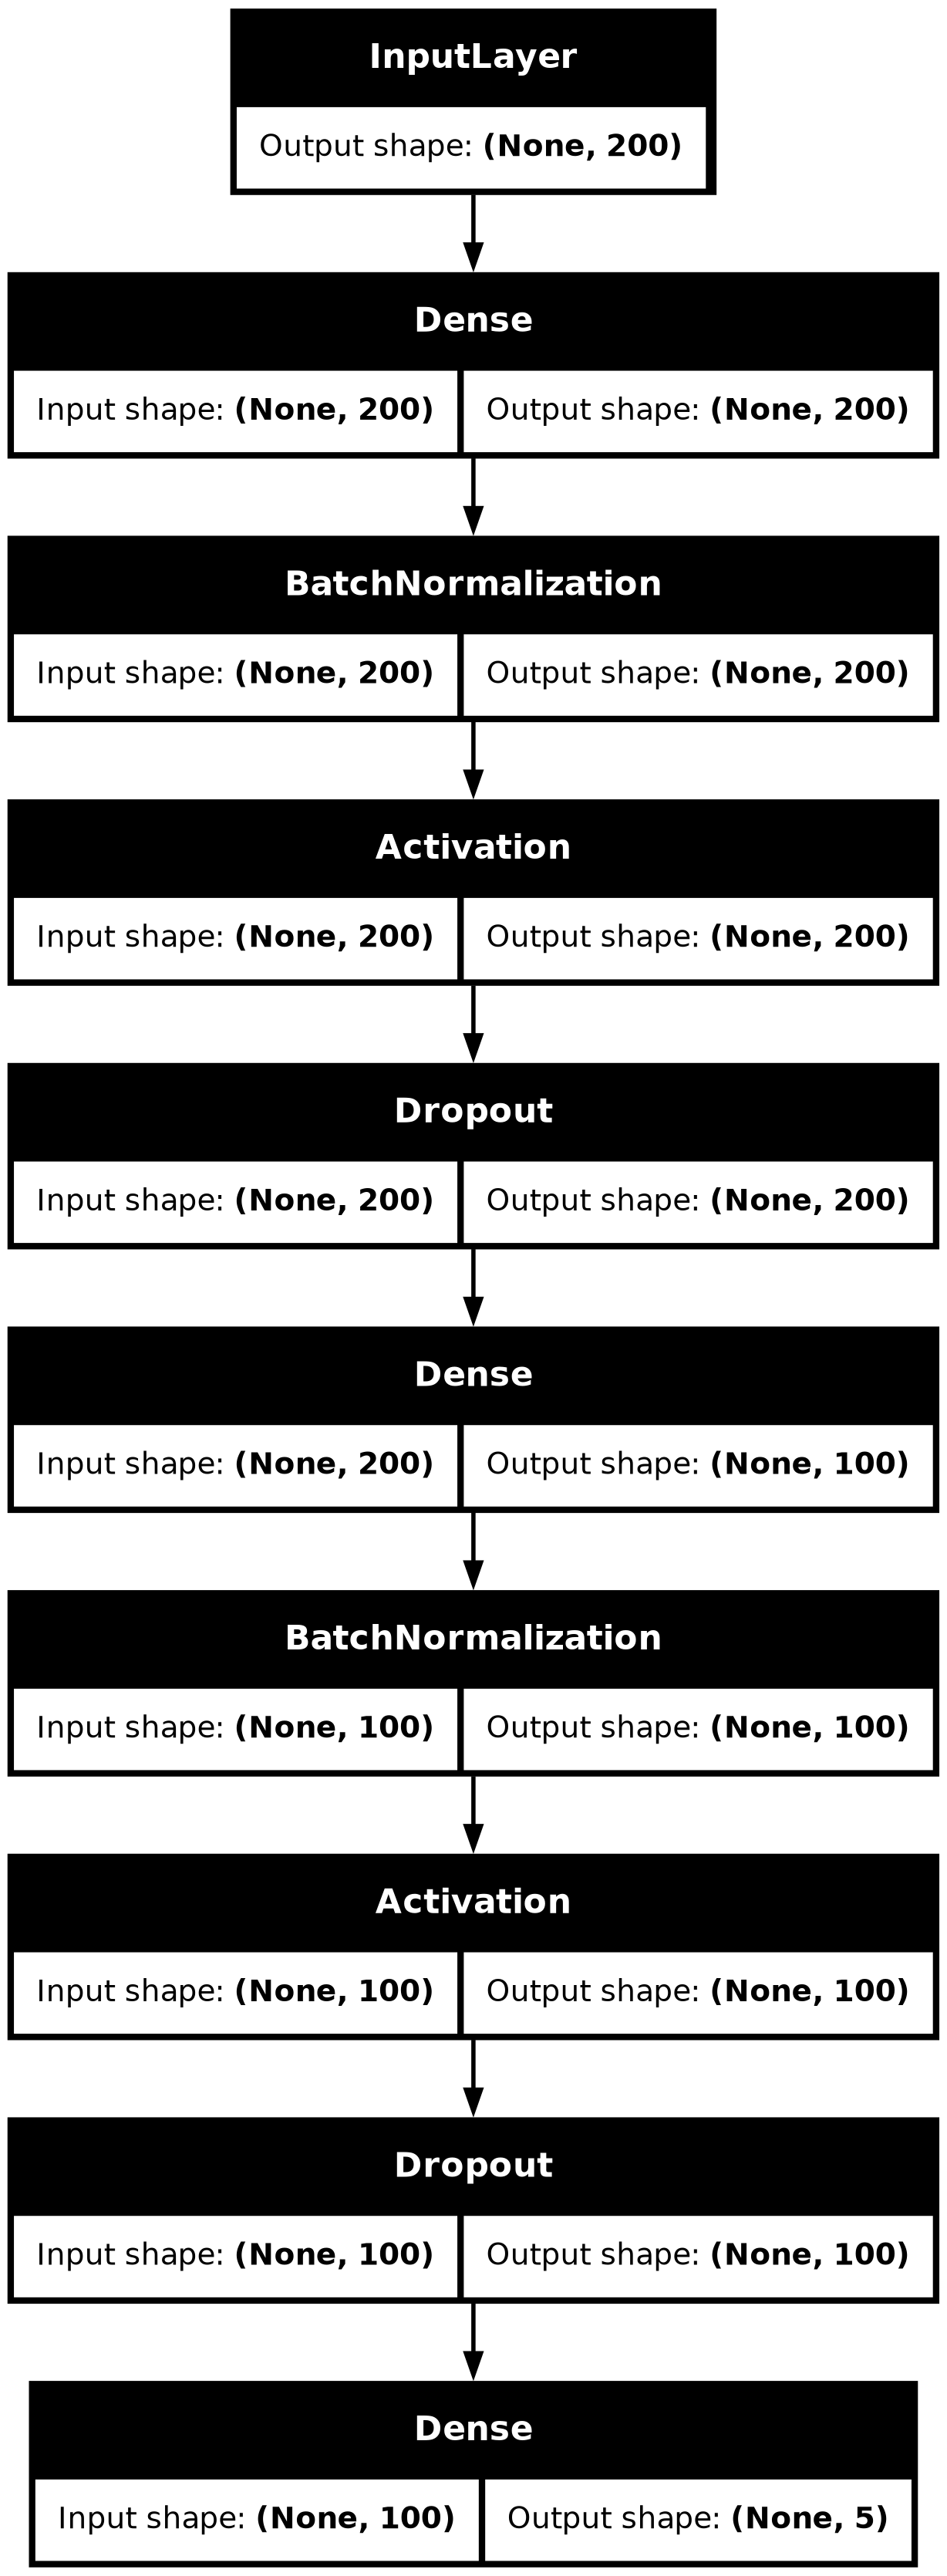

In [59]:
#neural network model summary and layers plot
nn.summary()
plot_model(nn, show_shapes=True)

In [60]:
#dictionary to store resultant accuracy from each model after testing them on test data
com_dic = {}

In [61]:
#testing each models and showing report
pred_test = mnb.predict(X_test)
com_dic["Multinomial NB"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"MULTINOMIAL NB TEST")

MULTINOMIAL NB TEST============>>>

Accuracy : 0.7592


Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.93      0.82      9711
           1       0.96      0.64      0.77      7460
           2       0.69      0.71      0.70      2421
           3       0.07      0.49      0.12        67
           4       0.68      0.53      0.59      2885

    accuracy                           0.76     22544
   macro avg       0.63      0.66      0.60     22544
weighted avg       0.79      0.76      0.76     22544


Confusion Matrix : 
 [[9041   34  291   44  301]
 [1800 4796  343  154  367]
 [ 498  172 1730   10   11]
 [   1    0    0   33   33]
 [ 996    2  150  221 1516]]


In [62]:
#testing each models and showing report
pred_test = bnb.predict(X_test)
com_dic["Bernoulli NB"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"BERNOULLI NB TEST")

BERNOULLI NB TEST============>>>

Accuracy : 0.7737


Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.94      0.84      9711
           1       0.96      0.63      0.76      7460
           2       0.65      0.84      0.73      2421
           3       0.10      0.48      0.16        67
           4       0.68      0.55      0.61      2885

    accuracy                           0.77     22544
   macro avg       0.63      0.69      0.62     22544
weighted avg       0.80      0.77      0.77     22544


Confusion Matrix : 
 [[9081    9  294   36  291]
 [1678 4708  643    8  423]
 [ 182  198 2036    3    2]
 [   1    0    0   32   34]
 [ 897    2  159  242 1585]]


In [63]:
#testing each models and showing report
pred_test = lr.predict(X_test)
com_dic["Logistic Regression"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"LOGISTIC REGRESSION TEST")

LOGISTIC REGRESSION TEST============>>>

Accuracy : 0.7540


Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.94      0.78      9711
           1       0.94      0.75      0.83      7460
           2       0.75      0.68      0.72      2421
           3       0.35      0.25      0.30        67
           4       0.82      0.20      0.32      2885

    accuracy                           0.75     22544
   macro avg       0.71      0.57      0.59     22544
weighted avg       0.79      0.75      0.73     22544


Confusion Matrix : 
 [[9126  213  312    9   51]
 [1594 5624  194    0   48]
 [ 578  174 1657    3    9]
 [  34    0    0   17   16]
 [2259    0   33   19  574]]


In [64]:
#testing each models and showing report
pred_test = rf.predict(X_test)
com_dic["Random Forest"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"RANDOM FOREST TEST")

RANDOM FOREST TEST============>>>

Accuracy : 0.7369


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.96      0.71      0.82      7460
           2       0.76      0.63      0.69      2421
           3       0.50      0.10      0.17        67
           4       0.98      0.11      0.20      2885

    accuracy                           0.74     22544
   macro avg       0.77      0.51      0.53     22544
weighted avg       0.80      0.74      0.70     22544


Confusion Matrix : 
 [[9445   58  202    2    4]
 [1881 5314  265    0    0]
 [ 715  176 1530    0    0]
 [  59    0    0    7    1]
 [2541    0   22    5  317]]


In [65]:
#testing each models and showing report
pred_test = svc.predict(X_test)
com_dic["Support Vector Machine"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"SUPPORT VECTOR MACHINE TEST")

SUPPORT VECTOR MACHINE TEST============>>>

Accuracy : 0.7449


Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.96      0.71      0.82      7460
           2       0.69      0.60      0.64      2421
           3       0.42      0.16      0.24        67
           4       0.89      0.21      0.33      2885

    accuracy                           0.74     22544
   macro avg       0.72      0.53      0.56     22544
weighted avg       0.79      0.74      0.72     22544


Confusion Matrix : 
 [[9415   59  216    4   17]
 [1680 5327  406    0   47]
 [ 800  175 1446    0    0]
 [  46    0    0   11   10]
 [2254    0   25   11  595]]


In [66]:
#testing each models and showing report
pred_test = list()
for pr in nn.predict(X_test) : pred_test.append(np.argmax(pr))
com_dic["Neural Network"] = get_acc(Y_test,pred_test)
show_report(Y_test,pred_test,"NEURAL NETWORK")

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
NEURAL NETWORK============>>>

Accuracy : 0.7357


Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.96      0.78      9711
           1       0.96      0.73      0.83      7460
           2       0.67      0.59      0.63      2421
           3       0.50      0.15      0.23        67
           4       0.96      0.12      0.21      2885

    accuracy                           0.74     22544
   macro avg       0.75      0.51      0.53     22544
weighted avg       0.79      0.74      0.70     22544


Confusion Matrix : 
 [[9324   70  305    2   10]
 [1595 5483  382    0    0]
 [ 824  162 1435    0    0]
 [  51    2    0   10    4]
 [2516    0   27    8  334]]


In [67]:
#Bar chart X=Models Y=Accuracy
#It comes out that Neural Network model work best among all
fig = px.bar(com_dic.keys(), y=com_dic.values(), title="Final Test Data Accuracy on different models", color=com_dic.keys())
fig.update_layout(font=dict(color="white"),plot_bgcolor='rgb(0,0,0)',paper_bgcolor='rgb(0,0,0)')  